# Proper randomization is important...

I changed the code of the MPI calibration code to do a global randomization (and not a randomization within each operation).

In [1]:
import os
import numpy
import pandas
from extract_archive import extract_zip, aggregate_dataframe
archive_names = {'nancy_2018-07-24_1621460.zip' : 'none', 'nancy_2018-07-27_1625117.zip' : 'half', 'nancy_2018-08-03_1645238.zip': 'full'}
alldf = []
aggr = []
for name, shuffled in archive_names.items():
    archive = extract_zip(name)
    df = archive['exp/exp_Recv.csv']
    df['batch_index'] = numpy.floor(df.index / 10).astype(int)
    df['batch_index_mod'] = df.batch_index % 50 # 50 batches of 10 calls
    info = archive['info.yaml']
    deployment = str(info['deployment'])
    df['deployment'] = deployment
    mpi_version = set([info[key]['mpi'] for key in info.keys() if 'grid5000' in key])
    assert len(mpi_version) == 1
    mpi_version = mpi_version.pop()
    df['mpi'] = mpi_version
    df['exp_type'] = mpi_version + ' | ' + deployment
    df['shuffled'] = shuffled
    alldf.append(df)
    aggr.append(aggregate_dataframe(df))
df = pandas.concat(alldf)
df_aggr = pandas.concat(aggr)
print(df.exp_type.unique())
df.head()

/home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/grvingt/extract_archive.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  deployment = yaml.load(input_zip.read('info.yaml'))['deployment']
/home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/grvingt/extract_archive.py:26: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  result[name] = yaml.load(input_zip.read(name))


['mpirun (Open MPI) 2.0.2 | False']


,op,msg_size,start,duration,experiment,type,deployment,index,batch_index,batch_index_mod,mpi,exp_type,shuffled
0,MPI_Recv,765921,0.003156,0.000077,nancy,exp/exp_Recv.csv,False,0,0,0,mpirun (Open MPI) 2.0.2,mpirun (Open MPI) 2.0.2 | False,none
1,MPI_Recv,765921,0.004077,0.000073,nancy,exp/exp_Recv.csv,False,1,0,0,mpirun (Open MPI) 2.0.2,mpirun (Open MPI) 2.0.2 | False,none
2,MPI_Recv,765921,0.004989,0.000073,nancy,exp/exp_Recv.csv,False,2,0,0,mpirun (Open MPI) 2.0.2,mpirun (Open MPI) 2.0.2 | False,none
3,MPI_Recv,765921,0.005903,0.000073,nancy,exp/exp_Recv.csv,False,3,0,0,mpirun (Open MPI) 2.0.2,mpirun (Open MPI) 2.0.2 | False,none
4,MPI_Recv,765921,0.006815,0.000073,nancy,exp/exp_Recv.csv,False,4,0,0,mpirun (Open MPI) 2.0.2,mpirun (Open MPI) 2.0.2 | False,none


In [2]:
df[['index', 'start', 'msg_size', 'duration', 'shuffled']].to_csv('/tmp/mpi_calibration_order.csv', index=False)

## Checking if the proper randomization gives better results

In [3]:
%matplotlib inline
from plotnine import *
import plotnine; plotnine.options.figure_size = 12, 8
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

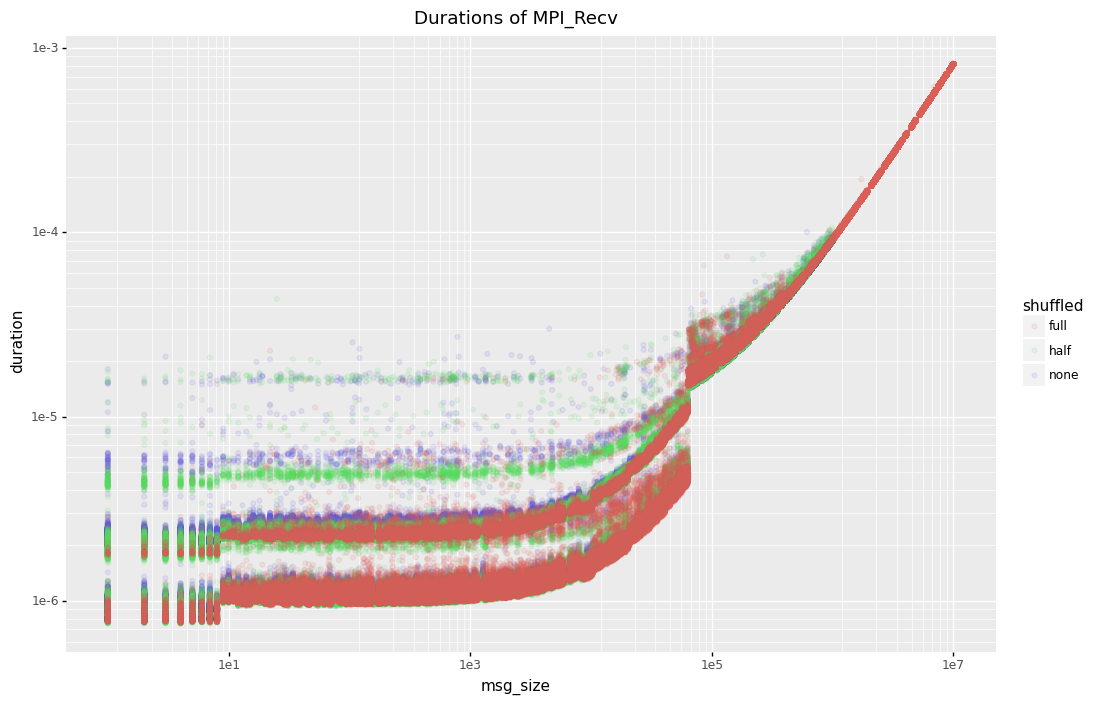

<ggplot: (8787381091830)>

In [4]:
ggplot(df, aes(x='msg_size', y='duration', color='shuffled')) + geom_point(alpha=0.1) + scale_x_log10() + scale_y_log10() + ggtitle('Durations of MPI_Recv')

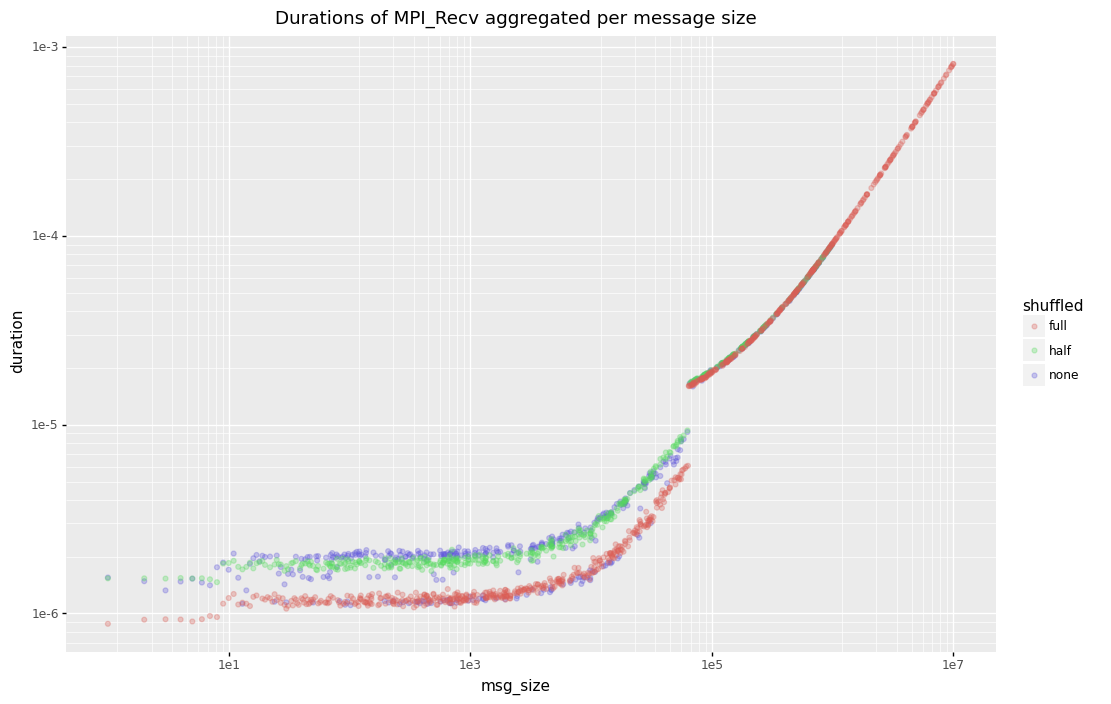

<ggplot: (-9223363249519531253)>

In [5]:
ggplot(df_aggr, aes(x='msg_size', y='duration', color='shuffled')) + geom_point(alpha=0.3) + scale_x_log10() + scale_y_log10() + ggtitle('Durations of MPI_Recv aggregated per message size')

Let's restrict ourselves to calls with a message size between 100 and 1000 (i.e., one of the places that was problematic).

In [6]:
df = df[(df.msg_size >= 1e2) & (df.msg_size < 1e3)].copy() # gosh, I hate pandas' default
df_aggr = df_aggr[(df_aggr.msg_size >= 1e2) & (df_aggr.msg_size < 1e3)].copy()
df = df[df.duration < df.duration.quantile(0.99)] # removing the extreme outliers...

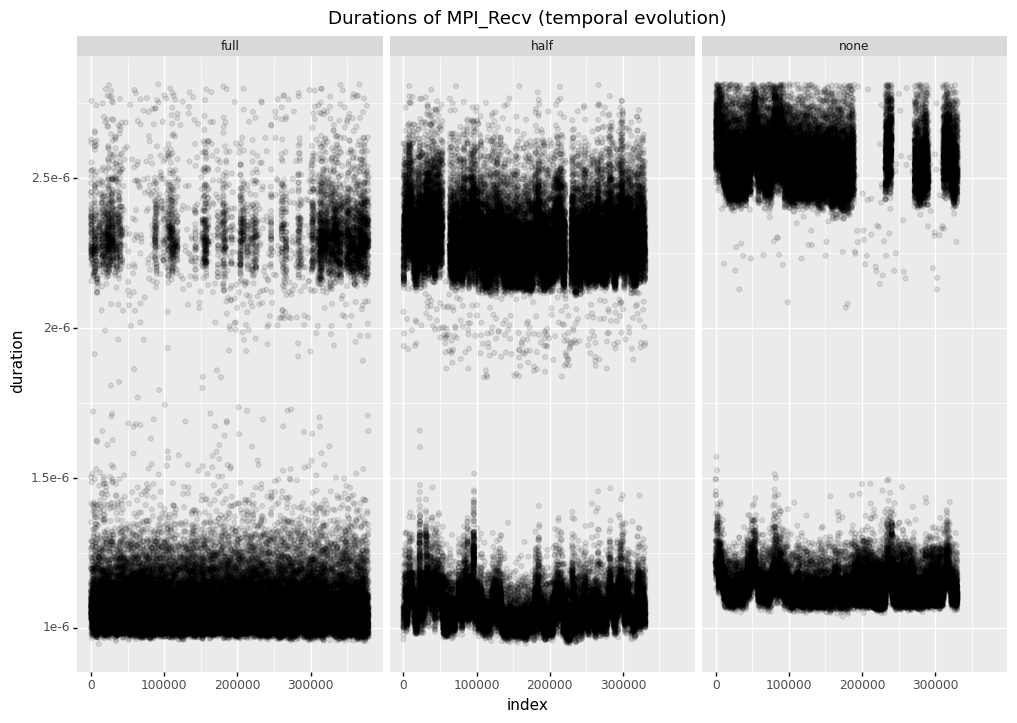

<ggplot: (8787373687970)>

In [7]:
ggplot(df, aes(x='index', y='duration')) + geom_point(alpha=0.1) + ggtitle('Durations of MPI_Recv (temporal evolution)') + facet_wrap('shuffled')

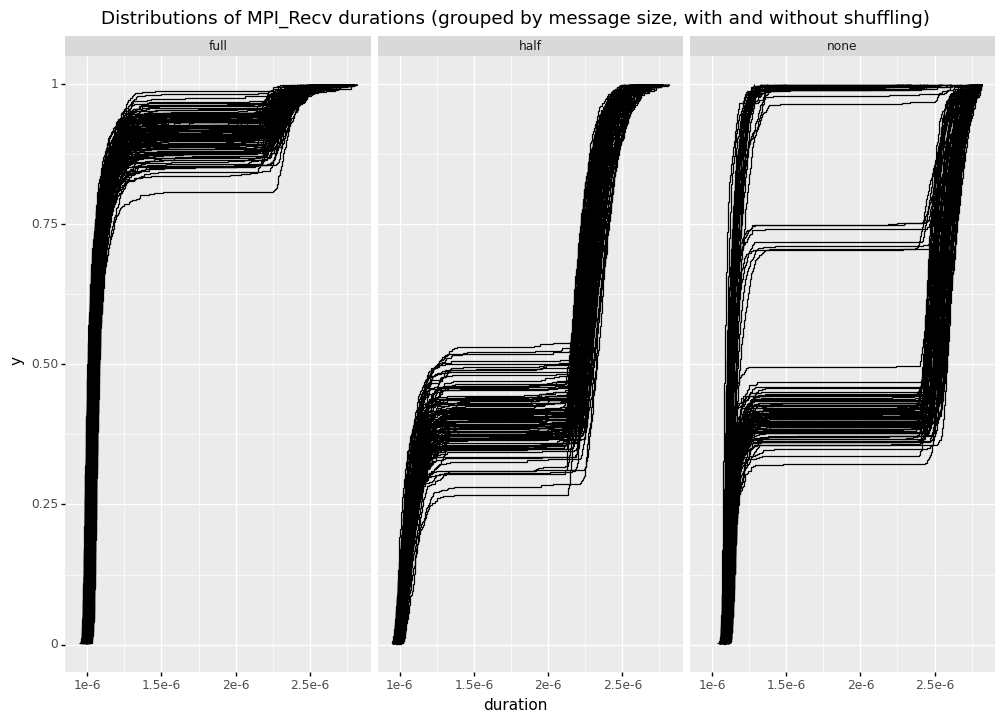

<ggplot: (-9223363249481076806)>

In [8]:
ggplot(df, aes('duration', group='msg_size')) + stat_ecdf() + ggtitle('Distributions of MPI_Recv durations (grouped by message size, with and without shuffling)') + facet_wrap('shuffled')

Weird, the bimodality is less important (but is still here), most of the operations have a low duration. Not sure if this due to the better randomization, or because of an external factor (e.g., the G5K team improved the performance tunings).